Imports!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sqlite3
import string
import seaborn as sns
import pickle

Connect to and read from imdb databases (SQL)

In [2]:
conn = sqlite3.connect('im.db')
imdb_basics_df = pd.read_sql("""
SELECT * FROM movie_basics
;""",conn)

In [3]:
imdb_reviews_df = pd.read_sql("""
SELECT * FROM movie_ratings
;""",conn)
imdb_reviews_df
imdb_basics_df = pd.merge(how='inner',left = imdb_basics_df,right = imdb_reviews_df,left_on = imdb_basics_df.movie_id,right_on=imdb_reviews_df.movie_id)
imdb_basics_df

,key_0,movie_id_x,primary_title,original_title,start_year,runtime_minutes,genres,movie_id_y,averagerating,numvotes
0,tt0063540,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",tt0063540,7.0,77
1,tt0066787,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",tt0066787,7.2,43
2,tt0069049,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,tt0069049,6.9,4517
3,tt0069204,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",tt0069204,6.1,13
4,tt0100275,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",tt0100275,6.5,119
...,...,...,...,...,...,...,...,...,...,...
73851,tt9913084,tt9913084,Diabolik sono io,Diabolik sono io,2019,75.0,Documentary,tt9913084,6.2,6
73852,tt9914286,tt9914286,Sokagin Çocuklari,Sokagin Çocuklari,2019,98.0,"Drama,Family",tt9914286,8.7,136
73853,tt9914642,tt9914642,Albatross,Albatross,2017,NaN,Documentary,tt9914642,8.5,8
73854,tt9914942,tt9914942,La vida sense la Sara Amat,La vida sense la Sara Amat,2019,NaN,None,tt9914942,6.6,5


Read The-Numbers.com movie budgets CSV file and call it the budget dataframe

In [4]:
budg_df = pd.read_csv('tn.movie_budgets.csv')

Create a list of unique genres which we will use to one-hot encode the genres

In [5]:
genres = []
genre_list = list(imdb_basics_df.genres.value_counts().keys())
for x in genre_list:
    row_genres = []
    for y in x.split(','):
        genres.append(y)
genres = list(set(genres))

Convert the 'genres' column into a series of lists instead of objects concatenated with a comma

In [6]:
imdb_basics_df['genres'] = imdb_basics_df.genres.str.split(',')

In [7]:
imdb_basics_df = imdb_basics_df.join(imdb_basics_df.genres.str.join('|').str.get_dummies())
imdb_basics_df.Action

0        1
1        0
2        0
3        0
4        0
        ..
73851    0
73852    0
73853    0
73854    0
73855    0
Name: Action, Length: 73856, dtype: int64

Loop over items in 'genres' and create the one-hot encoded columns

Here, we create a feature which is the sum of all user ratings. We will need this to create an average user rating later (weighted average)

In [8]:
imdb_basics_df['sum_rating'] = imdb_basics_df['averagerating'] * imdb_basics_df['numvotes']

We remove the punctuation and whitespace from the titles to create better matching

First make a list of all characters we want to remove

In [9]:
punct_list = list(string.punctuation) + [" "]
len(punct_list)

33

We do the replace and also set all titles to lowercase
We do this for the original title and the primary title, as well as for the titles in the budget dataframe

In [10]:
og_list = imdb_basics_df.original_title.str.lower()
for char in punct_list:
    og_list = og_list.str.replace(char,"")
og_list
imdb_basics_df['og_name'] = og_list

C:\Users\kapta\AppData\Local\Temp\ipykernel_17364\2743537487.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  og_list = og_list.str.replace(char,"")


In [11]:
prim_list = imdb_basics_df.primary_title.str.lower()
for char in punct_list:
    prim_list = prim_list.str.replace(char,"")
prim_list
imdb_basics_df['prim_name'] = prim_list

C:\Users\kapta\AppData\Local\Temp\ipykernel_17364\3155770604.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  prim_list = prim_list.str.replace(char,"")


In [12]:
budget_list = budg_df.movie.str.lower()
for char in punct_list:
    budget_list = budget_list.str.replace(char,"")
budget_list
budg_df['key_name'] = budget_list
budg_df

C:\Users\kapta\AppData\Local\Temp\ipykernel_17364\3876272036.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  budget_list = budget_list.str.replace(char,"")


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,key_name
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279",avatar
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",piratesofthecaribbeanonstrangertides
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350",darkphoenix
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963",avengersageofultron
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747",starwarsepviiithelastjedi
...,...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,"$7,000",$0,$0,red11
5778,79,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495",following
5779,80,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338",returntothelandofwonders
5780,81,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0,aplaguesopleasant


Next we create a list of titles to act as keys to match with the budget dataframe by checking which one has a match before using it.

In [13]:
key_titles = []
target = list(budget_list)
for i,v in enumerate(list(imdb_basics_df.prim_name.values)):
    x = imdb_basics_df.og_name.values[i]
    if v in target:
        key_titles.append(v)
    elif x in target:
        key_titles.append(x)
    else: key_titles.append(np.NaN)
imdb_basics_df['key_title'] = key_titles
len(list(set(key_titles)))

2294

Pickle this data

In [14]:
imdb_basics_df.to_pickle('./imdb_basics_df.zip',compression='zip')

Before we do our join, we drop duplicates.

In [15]:

imdb_basics_df.drop_duplicates(subset = 'key_title', inplace = True)

In [16]:
budg_df.drop_duplicates(subset = 'key_name', inplace = True)

Then we can do our join

In [17]:
imdb_basics_df.drop('key_0',axis = 1,inplace=True)

In [18]:
merged_df = pd.merge(how='inner',left = imdb_basics_df,right = budg_df,left_on = imdb_basics_df.key_title,right_on=budg_df.key_name)

Loop over list of column names where floats are saved as objects and strip characters.
Then, save them as floats.

In [19]:
objects_to_floats = ['production_budget','domestic_gross','worldwide_gross']

for x in objects_to_floats:
    merged_df[x] = merged_df[x].str.replace('$',"")
    merged_df[x] = merged_df[x].str.replace(',',"")
    merged_df[x] = merged_df[x].astype('float64')

C:\Users\kapta\AppData\Local\Temp\ipykernel_17364\1951103906.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  merged_df[x] = merged_df[x].str.replace('$',"")


Create a new column that calculates profitability of a film

In [20]:
merged_df['Profitability'] = merged_df.worldwide_gross - merged_df.production_budget

Here, we plot the profitability of a film against its budget. Note that most films are clustered near or below the break-even point

Text(0, 0.5, 'Profitability of Film')

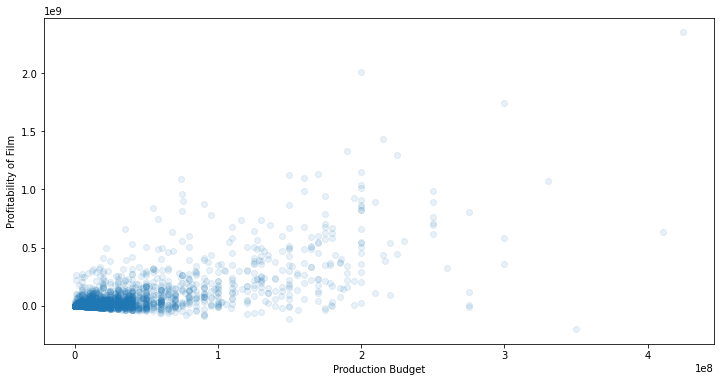

In [21]:
x=merged_df.production_budget
y=merged_df.Profitability
fig,ax = plt.subplots(figsize = (12,6))
ax.scatter(x,y,alpha=.1)
ax.set_xlabel('Production Budget')
ax.set_ylabel('Profitability of Film')
#ax.set_title('Profitability vs Production Budget');

Create a new feature for the ROI

In [22]:
merged_df['ROI_ratio'] = merged_df.Profitability / merged_df.production_budget

Use boolean mask created by one-hot encoded variables to create a dataframe holding the budget for each genre

In [23]:
dfb = pd.DataFrame(merged_df.production_budget)
for i,x in enumerate(genres):
    dfb[x] = merged_df[x] * merged_df.production_budget
dfb

,production_budget,Action,Comedy,Short,Thriller,Musical,Western,Fantasy,Mystery,History,...,Game-Show,Crime,Sport,Music,Sci-Fi,Reality-TV,Family,Adventure,Adult,War
0,45000000.0,45000000.0,45000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,200000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,25000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25000000.0,0.0,0.0
3,91000000.0,0.0,91000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91000000.0,0.0,0.0
4,28000000.0,28000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,28000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288,9200000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2289,400000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2290,38000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2291,6000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Use boolean mask created by one-hot encoded variables to create a dataframe holding the profitability for each genre

In [24]:
dfp = pd.DataFrame(merged_df.Profitability)
for i,x in enumerate(genres):
    dfp[x] = merged_df[x] * merged_df.Profitability
dfp

,Profitability,Action,Comedy,Short,Thriller,Musical,Western,Fantasy,Mystery,History,...,Game-Show,Crime,Sport,Music,Sci-Fi,Reality-TV,Family,Adventure,Adult,War
0,-44926294.0,-44926294.0,-44926294.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
1,965996.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-15686698.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-15686698.0,-0.0,-0.0
3,96861183.0,0.0,96861183.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96861183.0,0.0,0.0
4,34108587.0,34108587.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,34108587.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288,-5000666.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
2289,255538.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2290,11678401.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2291,12107621.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
col_names = list(dfp.columns)[1:]

Create bar charts of ROI by genre and profitability by genre

C:\Users\kapta\AppData\Local\Temp\ipykernel_17364\2110147724.py:4: RuntimeWarning: invalid value encountered in true_divide
  vals = pd.Series(profits.values / costs.values)


Text(0, 0.5, 'ROI (Profit per Dollar Spend)')

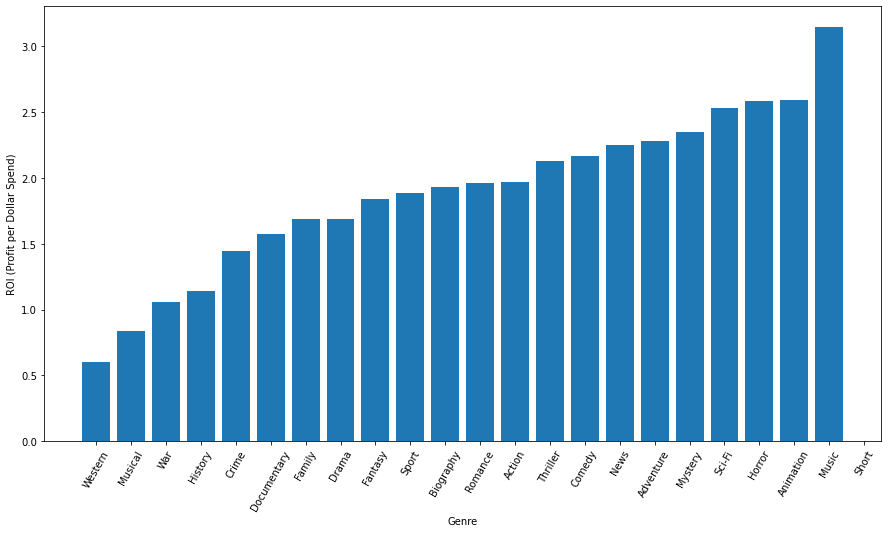

In [26]:
profits = dfp.sum(axis=0)[1:]
costs = dfb.sum(axis=0)[1:]

vals = pd.Series(profits.values / costs.values)

df_chart = pd.DataFrame(genres,columns=['genres'])
df_chart['average_ROI'] = vals
df_chart = df_chart.sort_values(by = 'average_ROI')
x =  df_chart.genres
y = df_chart.average_ROI
fig,ax=plt.subplots(figsize=(15,8))
plt.xticks(rotation = 60)
ax.bar(x,y)
ax.set_xlabel('Genre')
ax.set_ylabel('ROI (Profit per Dollar Spend)')
#ax.set_title('Average ROI by Genre')

Text(0, 0.5, 'Profitability (Total Profit for Film)')

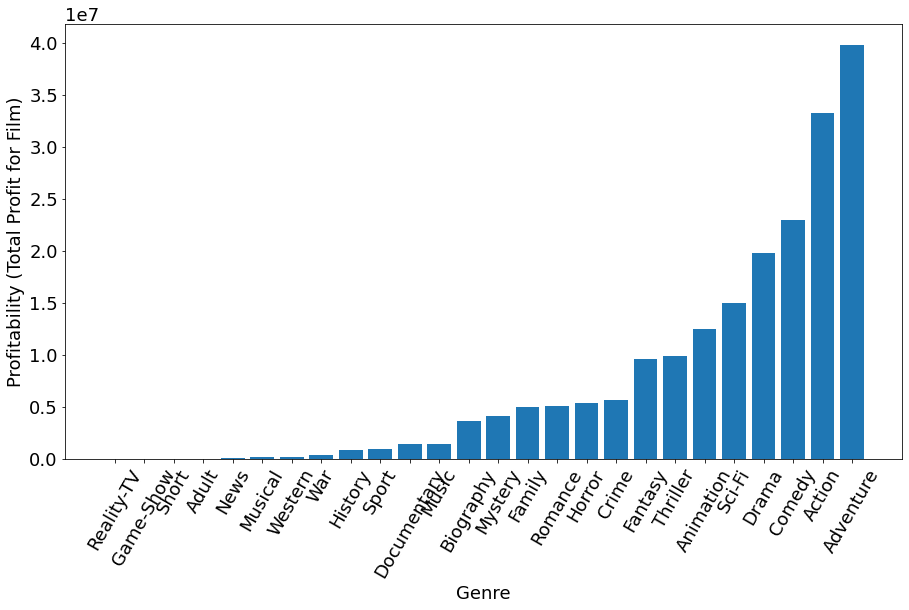

In [27]:
vals = dfp.mean(axis=0)[1:].sort_values()
plt.rcParams.update({'font.size': 18})
x = vals.keys()
y = vals.values
fig,ax=plt.subplots(figsize=(15,8))
plt.xticks(rotation = 60)
ax.bar(x,y)
ax.set_xlabel('Genre')
ax.set_ylabel('Profitability (Total Profit for Film)')
#ax.set_title('Average Profitability by Genre')

Create new column for number of Genres

In [28]:
merged_df['number_of_genres'] = merged_df.genres.str.len()


Create charts showing the number of genres against ROI and Profitability

Text(0, 0.5, 'Average Profitability for Films)')

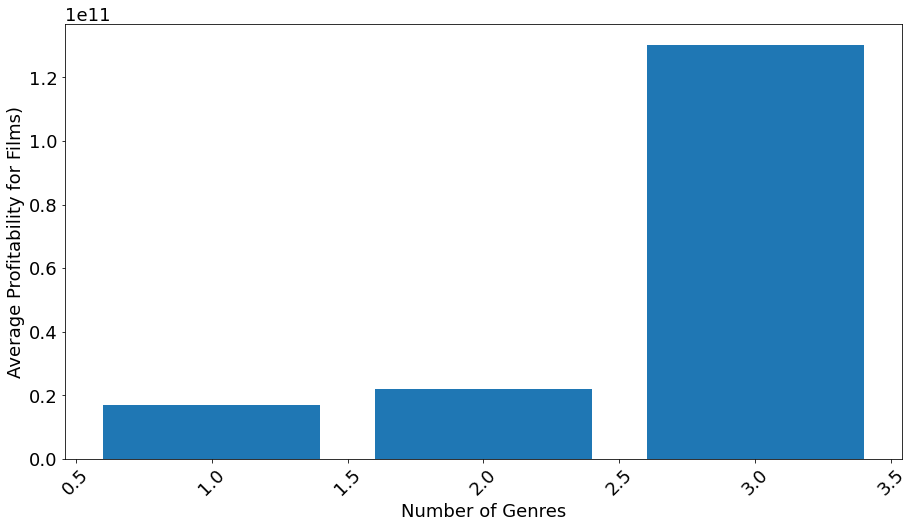

In [29]:
chart_data = merged_df.groupby('number_of_genres').sum()

x = chart_data.index
y = chart_data['Profitability']
fig,ax=plt.subplots(figsize=(15,8))
plt.xticks(rotation = 45)
ax.bar(x,y)
ax.set_xlabel('Number of Genres')
ax.set_ylabel('Average Profitability for Films)')
#ax.set_title('Average Profitability by Number of Genres')

Text(0, 0.5, 'Profitability (Average ROI for Films)')

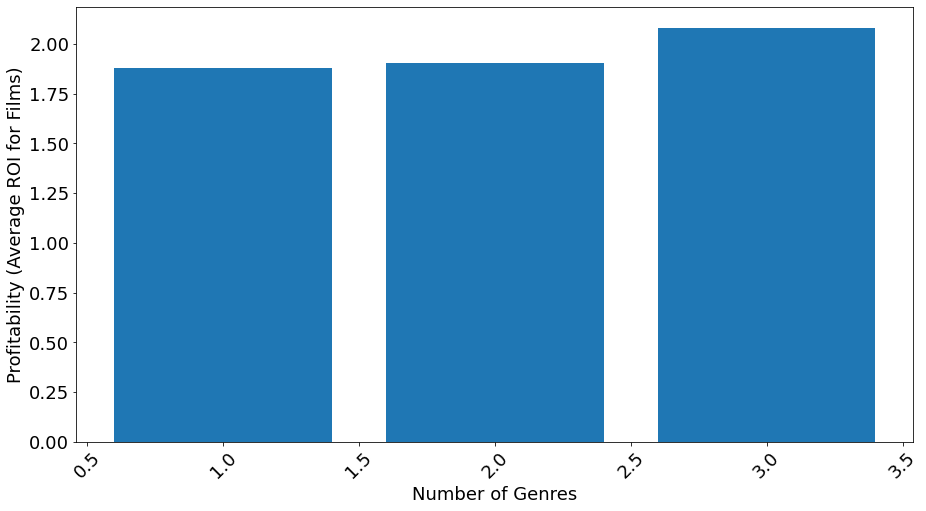

In [30]:
x = chart_data.index
y = chart_data['Profitability']/chart_data['production_budget']
fig,ax=plt.subplots(figsize=(15,8))
plt.xticks(rotation = 45)
ax.bar(x,y)
ax.set_xlabel('Number of Genres')
ax.set_ylabel('Profitability (Average ROI for Films)')
#ax.set_title('Average ROI by Number of Genres')

Use boolean mask to make values for the number of votes for each genre and graph the various genres

In [31]:
dfn = pd.DataFrame(imdb_basics_df.numvotes)
for i,x in enumerate(genres):
    dfn[x] = imdb_basics_df[x] * imdb_basics_df.numvotes

Text(0, 0.5, 'Average Number of Ratings for Films)')

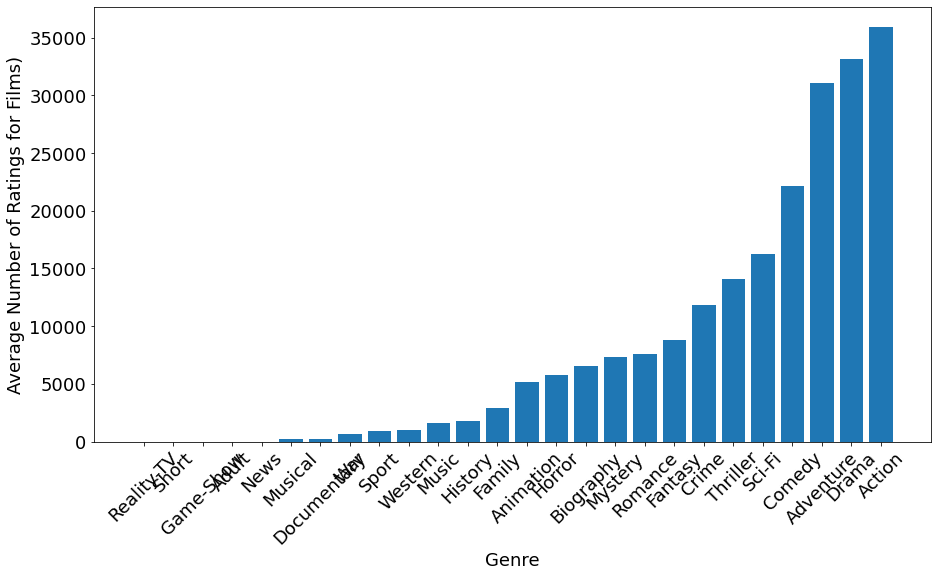

In [32]:
vals = dfn.mean(axis=0)[1:].sort_values()
x = vals.keys()
y = vals.values
fig,ax=plt.subplots(figsize=(15,8))
plt.xticks(rotation = 45)
ax.bar(x,y)
ax.set_xlabel('Genre')
ax.set_ylabel('Average Number of Ratings for Films)')
#ax.set_title('Average Number of Ratings by Genre')

Use boolean mask to make values for the number of votes for each genre and graph the various genres

In [33]:
dfr = pd.DataFrame(imdb_basics_df.sum_rating)
for i,x in enumerate(genres):
    dfr[x] = imdb_basics_df[x] * imdb_basics_df.sum_rating

Text(0, 0.5, 'Average Film Rating')

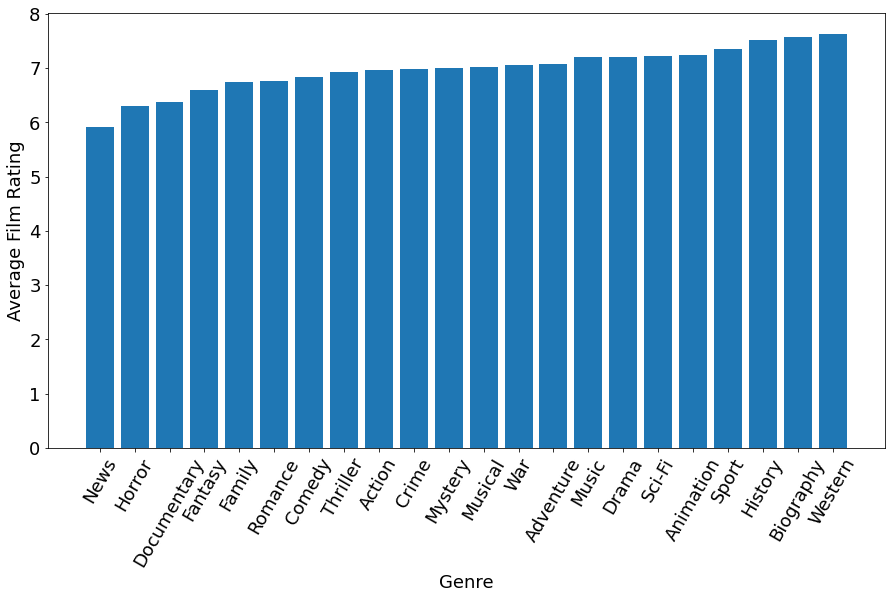

In [34]:
df_chart = pd.DataFrame(dfn.sum(axis=0)[1:],columns=['num_ratings'])
df_chart['sum_ratings'] = dfr.sum(axis=0)[1:].values
df_chart['average_rating'] = df_chart.sum_ratings / df_chart.num_ratings
df_chart = df_chart.sort_values(by='average_rating')
df_chart.dropna(inplace=True)
df_chart
x = df_chart.index
y = df_chart.average_rating
fig,ax=plt.subplots(figsize=(15,8))
plt.xticks(rotation = 60)
ax.bar(x,y)
ax.set_xlabel('Genre')
ax.set_ylabel('Average Film Rating')
#ax.set_title('Average Rating by Genre')